# Import

In [1]:
from numpy.random import seed
import sqlite3
import time
import numpy as np
import random
import pandas as pd
from pandas import DataFrame
import math
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import label_binarize
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.svm import SVC
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.ensemble import GradientBoostingClassifier

import sys
# sys.path.append('../input/rangerdeeplearningoptimizer/ranger')
# from ranger import Ranger

import warnings
import os
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn.functional as F

seed = 0
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
warnings.filterwarnings("ignore")

# Hyperparamters

In [2]:
file_path = "./"
feature_list = ["category", "target", "pathway", "enzyme"]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vector_size = 572*2

# drop_out_rating = 0.3
batch_size = 256
learn_rating = 1e-3
epo_num = 3
weight_decay_rate = 1e-3
cv = 5
patience = 7
delta = 0

### Early stopping

In [3]:
class EarlyStopping:
    def __init__(self, patience=7, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss, model, path):
        # print("val_loss={}".format(val_loss))
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model, path)
        elif score < self.best_score + self.delta:
            self.counter += 1
            # print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model, path)
            self.counter = 0

    def save_checkpoint(self, val_loss, model, path):
        if self.verbose:
            print(f"Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...")
        torch.save(model.state_dict(), path + "/" + "model_checkpoint.pth")
        self.val_loss_min = val_loss

### Ranger Optimizer

In [4]:
# https://github.com/lessw2020/Ranger-Deep-Learning-Optimizer
from torch.optim.optimizer import Optimizer
class Ranger(Optimizer):

    def __init__(self, params, lr=1e-3,                       # lr
                 alpha=0.5, k=6, N_sma_threshhold=5,           # Ranger options
                 betas=(.95, 0.999), eps=1e-5, weight_decay=0,  # Adam options
                 # Gradient centralization on or off, applied to conv layers only or conv + fc layers
                 use_gc=True, gc_conv_only=False
                 ):

        # parameter checks
        if not 0.0 <= alpha <= 1.0:
            raise ValueError(f'Invalid slow update rate: {alpha}')
        if not 1 <= k:
            raise ValueError(f'Invalid lookahead steps: {k}')
        if not lr > 0:
            raise ValueError(f'Invalid Learning Rate: {lr}')
        if not eps > 0:
            raise ValueError(f'Invalid eps: {eps}')


        # prep defaults and init torch.optim base
        defaults = dict(lr=lr, alpha=alpha, k=k, step_counter=0, betas=betas,
                        N_sma_threshhold=N_sma_threshhold, eps=eps, weight_decay=weight_decay)
        super().__init__(params, defaults)

        # adjustable threshold
        self.N_sma_threshhold = N_sma_threshhold

        # look ahead params

        self.alpha = alpha
        self.k = k

        # radam buffer for state
        self.radam_buffer = [[None, None, None] for ind in range(10)]

        # gc on or off
        self.use_gc = use_gc

        # level of gradient centralization
        self.gc_gradient_threshold = 3 if gc_conv_only else 1

        print(
            f"Ranger optimizer loaded. \nGradient Centralization usage = {self.use_gc}")
        if (self.use_gc and self.gc_gradient_threshold == 1):
            print(f"GC applied to both conv and fc layers")
        elif (self.use_gc and self.gc_gradient_threshold == 3):
            print(f"GC applied to conv layers only")

    def __setstate__(self, state):
        print("set state called")
        super(Ranger, self).__setstate__(state)

    def step(self, closure=None):
        loss = None

        # Evaluate averages and grad, update param tensors
        for group in self.param_groups:

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data.float()

                if grad.is_sparse:
                    raise RuntimeError(
                        'Ranger optimizer does not support sparse gradients')

                p_data_fp32 = p.data.float()

                state = self.state[p]  # get state dict for this param

                if len(state) == 0:  

                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p_data_fp32)
                    state['exp_avg_sq'] = torch.zeros_like(p_data_fp32)

                    # look ahead weight storage now in state dict
                    state['slow_buffer'] = torch.empty_like(p.data)
                    state['slow_buffer'].copy_(p.data)

                else:
                    state['exp_avg'] = state['exp_avg'].type_as(p_data_fp32)
                    state['exp_avg_sq'] = state['exp_avg_sq'].type_as(
                        p_data_fp32)

                # begin computations
                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']

                # GC operation for Conv layers and FC layers
                if grad.dim() > self.gc_gradient_threshold:
                    grad.add_(-grad.mean(dim=tuple(range(1, grad.dim())), keepdim=True))

                state['step'] += 1

                # compute variance mov avg
                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                # compute mean moving avg
                exp_avg.mul_(beta1).add_(1 - beta1, grad)

                buffered = self.radam_buffer[int(state['step'] % 10)]

                if state['step'] == buffered[0]:
                    N_sma, step_size = buffered[1], buffered[2]
                else:
                    buffered[0] = state['step']
                    beta2_t = beta2 ** state['step']
                    N_sma_max = 2 / (1 - beta2) - 1
                    N_sma = N_sma_max - 2 * \
                        state['step'] * beta2_t / (1 - beta2_t)
                    buffered[1] = N_sma
                    if N_sma > self.N_sma_threshhold:
                        step_size = math.sqrt((1 - beta2_t) * (N_sma - 4) / (N_sma_max - 4) * (
                            N_sma - 2) / N_sma * N_sma_max / (N_sma_max - 2)) / (1 - beta1 ** state['step'])
                    else:
                        step_size = 1.0 / (1 - beta1 ** state['step'])
                    buffered[2] = step_size

                if group['weight_decay'] != 0:
                    p_data_fp32.add_(-group['weight_decay']
                                     * group['lr'], p_data_fp32)

                # apply lr
                if N_sma > self.N_sma_threshhold:
                    denom = exp_avg_sq.sqrt().add_(group['eps'])
                    p_data_fp32.addcdiv_(-step_size *
                                         group['lr'], exp_avg, denom)
                else:
                    p_data_fp32.add_(-step_size * group['lr'], exp_avg)

                p.data.copy_(p_data_fp32)

                # integrated look ahead...
                # we do it at the param level instead of group level
                if state['step'] % group['k'] == 0:
                    # get access to slow param tensor
                    slow_p = state['slow_buffer']
                    # (fast weights - slow weights) * alpha
                    slow_p.add_(self.alpha, p.data - slow_p)
                    # copy interpolated weights to RAdam param tensor
                    p.data.copy_(slow_p)

        return loss

# Data

In [5]:
df_drug = pd.read_csv("drug_features.csv")
extraction = pd.read_csv("extraction.csv")
mechanism = extraction["mechanism"]
action = extraction["action"]
drugA = extraction["drugA"]
drugB = extraction["drugB"]


# Preprocess

In [6]:
def prepare(df_drug, feature_list, mechanism, action, drugA, drugB):
    d_label = {}
    d_feature = {}

    # Transfrom the interaction event to number
    d_event = []
    for i in range(len(mechanism)):
        d_event.append(mechanism[i] + " " + action[i])

    count = {}
    for i in d_event:
        if i in count:
            count[i] += 1
        else:
            count[i] = 1
    event_num = len(count)
    list1 = sorted(count.items(), key=lambda x: x[1], reverse=True)
    for i in range(len(list1)):
        d_label[list1[i][0]] = i

    vector = np.zeros((len(np.array(df_drug['name']).tolist()), 0), dtype=float)  # vector=[]
    for i in feature_list:
        # vector = np.hstack((vector, feature_vector(i, df_drug, vector_size)))#1258*1258
        tempvec = feature_vector(i, df_drug)
        vector = np.hstack((vector, tempvec))
    # Transfrom the drug ID to feature vector
    for i in range(len(np.array(df_drug['name']).tolist())):
        d_feature[np.array(df_drug['name']).tolist()[i]] = vector[i]

    # Use the dictionary to obtain feature vector and label
    new_feature = []
    new_label = []

    for i in range(len(d_event)):
        temp = np.hstack((d_feature[drugA[i]], d_feature[drugB[i]]))
        new_feature.append(temp)
        new_label.append(d_label[d_event[i]])

    new_feature = np.array(new_feature)  # 323539*....
    new_label = np.array(new_label)  # 323539

    return new_feature, new_label, event_num

# In[104]:


def feature_vector(feature_name, df):
    def Jaccard(matrix):
        matrix = np.mat(matrix)

        numerator = matrix * matrix.T

        denominator = np.ones(np.shape(matrix)) * matrix.T + matrix * np.ones(np.shape(matrix.T)) - matrix * matrix.T

        return numerator / denominator

    all_feature = []
    drug_list = np.array(df[feature_name]).tolist()
    # Features for each drug, for example, when feature_name is target, drug_list=["P30556|P05412","P28223|P46098|……"]
    for i in drug_list:
        for each_feature in i.split('|'):
            if each_feature not in all_feature:
                all_feature.append(each_feature)  # obtain all the features
    feature_matrix = np.zeros((len(drug_list), len(all_feature)), dtype=float)
    df_feature = DataFrame(feature_matrix, columns=all_feature)  # Consrtuct feature matrices with key of dataframe
    for i in range(len(drug_list)):
        for each_feature in df[feature_name].iloc[i].split('|'):
            df_feature[each_feature].iloc[i] = 1

    df_feature = np.array(df_feature)
    sim_matrix = np.array(Jaccard(df_feature))

    print(feature_name + " len is:" + str(len(sim_matrix[0])))
    return sim_matrix


# In[105]:


class DDIDataset(Dataset):
    def __init__(self, x, y):
        self.len = len(x)
        self.x_data = torch.from_numpy(x)

        self.y_data = torch.from_numpy(y)

    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    def __len__(self):
        return self.len

In [7]:
new_feature, new_label, event_num = prepare(
    df_drug, feature_list, mechanism, action, drugA, drugB
)
np.random.seed(seed)
np.random.shuffle(new_feature)
np.random.seed(seed)
np.random.shuffle(new_label)
print("dataset len", len(new_feature))

category len is:572
target len is:572
pathway len is:572
enzyme len is:572
dataset len 1025


In [8]:
new_feature.shape, new_label.shape

((1025, 4576), (1025,))

# Model

## CNN-Siam

In [9]:
class CNN_DDI(nn.Module):
    def __init__(self):
        super(CNN_DDI, self).__init__()
        self.conv1 = nn.Conv2d(2, 64, (3, 1), padding=(1, 0))
        self.conv2 = nn.Conv2d(64, 128, (3, 1), padding=(1, 0))
        self.conv3_1 = nn.Conv2d(128, 128, (3, 1), padding=(1, 0))
        self.conv3_2 = nn.Conv2d(128, 128, (3, 1), padding=(1, 0))
        self.conv4 = nn.Conv2d(128, 256, (3, 1), padding=(1, 0))
        self.fc1 = nn.Linear(256 * 572 * 4, 256)  # Adjust feature_size based on your input dimensions
        self.fc2 = nn.Linear(256, event_num)  # Assuming 65 DDI types

    def forward(self, x):
        x = x.reshape(-1, 2, 572, 4)
        x = F.leaky_relu(self.conv1(x))
        x = F.leaky_relu(self.conv2(x))
        identity = x
        x = F.leaky_relu(self.conv3_1(x))
        x = self.conv3_2(x)
        x += identity
        x = F.leaky_relu(x)
        x = F.leaky_relu(self.conv4(x))
        x = torch.flatten(x, 1)
        x = F.leaky_relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=1)

loss fn

In [10]:
class focal_loss(nn.Module):
    def __init__(self, gamma=2):
        super(focal_loss, self).__init__()

        self.gamma = gamma

    def forward(self, preds, labels):
        # assert preds.dim() == 2 and labels.dim()==1
        labels = labels.view(-1, 1).type(torch.int64)  # [B * S, 1]
        preds = preds.view(-1, preds.size(-1))  # [B * S, C]

        preds_logsoft = F.log_softmax(preds, dim=1)  # 先softmax, 然后取log
        preds_softmax = torch.exp(preds_logsoft)  # softmax

        preds_softmax = preds_softmax.gather(1, labels)  # 这部分实现nll_loss ( crossempty = log_softmax + nll )
        preds_logsoft = preds_logsoft.gather(1, labels)

        loss = -torch.mul(torch.pow((1 - preds_softmax), self.gamma),
                          preds_logsoft)  # torch.pow((1-preds_softmax), self.gamma) 为focal loss中 (1-pt)**γ

        loss = loss.mean()

        return loss


# def mixup(x1, x2, y1, y2, alpha):
#     beta = np.random.beta(alpha, alpha)
#     x = beta * x1 + (1 - beta) * x2
#     y = beta * y1 + (1 - beta) * y2
#     return x, y


# TEST PIPELINE

In [11]:
inp = torch.randn(2, 2, 572, 4)
mod = CNN_DDI()
mod(inp).shape

torch.Size([2, 30])

# Training

In [12]:
from torch.optim.lr_scheduler import CosineAnnealingLR

train_epochs_loss = []
valid_epochs_loss = []

def train_fn(model, x_train, y_train, x_test, y_test, event_num):
    # optimizer = torch.optim.Adam(model.parameters(), lr=learn_rating, weight_decay=weight_decay_rate)
    # optimizer = optim.RAdam(model.parameters(), lr=learn_rating, weight_decay=weight_decay_rate)

    # Ranger(RAdam+LookAhead) + CosineAnnealingLR: 50epochs一个半周期
    optimizer = Ranger(model.parameters(), lr=learn_rating, weight_decay=weight_decay_rate, betas=(0.95, 0.999), eps=1e-6)
    scheduler = CosineAnnealingLR(optimizer, T_max=epo_num, eta_min=1e-6)


    my_loss = focal_loss()
    model = model.to(device)
    earlystop = EarlyStopping(patience=patience, delta=delta)

    x_train = np.vstack(
        (
            x_train,
            np.hstack(
                (x_train[:, len(x_train[0]) // 2 :], x_train[:, : len(x_train[0]) // 2])
            ),
        )
    )
    y_train = np.hstack((y_train, y_train))
    np.random.seed(seed)
    np.random.shuffle(x_train)
    np.random.seed(seed)
    np.random.shuffle(y_train)

    len_train = len(y_train)
    len_test = len(y_test)
    print("arg train len", len(y_train))
    print("test len", len(y_test))

    train_dataset = DDIDataset(x_train, np.array(y_train))
    test_dataset = DDIDataset(x_test, np.array(y_test))
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

    for epoch in range(epo_num):

        running_loss = 0.0

        model.train()
        for batch_idx, data in enumerate(train_loader, 0):
            x, y = data

            # mixup
            lam = np.random.beta(0.5, 0.5)
            index = torch.randperm(x.size()[0])
            inputs = lam * x + (1 - lam) * x[index, :]

            targets_a, targets_b = y, y[index]

            inputs = inputs.to(device)
            targets_a = targets_a.to(device)
            targets_b = targets_b.to(device)

            optimizer.zero_grad()
            # forward + backward+update
            pred = model(inputs.float())

            loss = lam * my_loss(pred, targets_a) + (1 - lam) * my_loss(pred, targets_b)

            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        model.eval()
        testing_loss = 0.0
        with torch.no_grad():
            for batch_idx, data in enumerate(test_loader, 0):
                inputs, target = data

                inputs = inputs.to(device)

                target = target.to(device)

                pred = model(inputs.float())

                loss = my_loss(pred, target)
                testing_loss += loss.item()
        # if epoch+1 % 5 == 0:
        print(
            "epoch [%d] loss: %.6f testing_loss: %.6f "
            % (epoch + 1, running_loss / len_train, testing_loss / len_test)
        )
        
        train_epochs_loss.append(running_loss / len_train)
        valid_epochs_loss.append(testing_loss / len_test)
        earlystop(valid_epochs_loss[-1], model, file_path)
        if earlystop.early_stop:
            print("Early stopping\n")
            break


    pre_score = np.zeros((0, event_num), dtype=float)
    model.eval()
    with torch.no_grad():
        for batch_idx, data in enumerate(test_loader, 0):
            inputs, _ = data
            inputs = inputs.to(device)
            X = model(inputs.float())
            pre_score = np.vstack((pre_score, F.softmax(X).cpu().numpy()))
    return pre_score


## Evaluation fn

In [13]:
def roc_aupr_score(y_true, y_score, average="macro"):
    def _binary_roc_aupr_score(y_true, y_score):
        precision, recall, pr_thresholds = precision_recall_curve(y_true, y_score)
        return auc(recall, precision)

    def _average_binary_score(
        binary_metric, y_true, y_score, average
    ):  # y_true= y_one_hot
        if average == "binary":
            return binary_metric(y_true, y_score)
        if average == "micro":
            y_true = y_true.ravel()
            y_score = y_score.ravel()
        if y_true.ndim == 1:
            y_true = y_true.reshape((-1, 1))
        if y_score.ndim == 1:
            y_score = y_score.reshape((-1, 1))
        n_classes = y_score.shape[1]
        score = np.zeros((n_classes,))
        for c in range(n_classes):
            y_true_c = y_true.take([c], axis=1).ravel()
            y_score_c = y_score.take([c], axis=1).ravel()
            score[c] = binary_metric(y_true_c, y_score_c)
        return np.average(score)

    return _average_binary_score(_binary_roc_aupr_score, y_true, y_score, average)


def evaluate(pred_type, pred_score, y_test, event_num):
    all_eval_type = 11
    result_all = np.zeros((all_eval_type, 1), dtype=float)
    each_eval_type = 6
    result_eve = np.zeros((event_num, each_eval_type), dtype=float)
    y_one_hot = label_binarize(y_test, classes=range(event_num))
    pred_one_hot = label_binarize(pred_type, classes=range(event_num))
    result_all[0] = accuracy_score(y_test, pred_type)
    result_all[1] = roc_aupr_score(y_one_hot, pred_score, average="micro")
    result_all[2] = roc_aupr_score(y_one_hot, pred_score, average="macro")
    result_all[3] = roc_auc_score(y_one_hot, pred_score, average="micro")
    result_all[4] = roc_auc_score(y_one_hot, pred_score, average="macro")
    result_all[5] = f1_score(y_test, pred_type, average="micro")
    result_all[6] = f1_score(y_test, pred_type, average="macro")
    result_all[7] = precision_score(y_test, pred_type, average="micro")
    result_all[8] = precision_score(y_test, pred_type, average="macro")
    result_all[9] = recall_score(y_test, pred_type, average="micro")
    result_all[10] = recall_score(y_test, pred_type, average="macro")
    for i in range(event_num):
        result_eve[i, 0] = accuracy_score(
            y_one_hot.take([i], axis=1).ravel(), pred_one_hot.take([i], axis=1).ravel()
        )
        result_eve[i, 1] = roc_aupr_score(
            y_one_hot.take([i], axis=1).ravel(),
            pred_one_hot.take([i], axis=1).ravel(),
            average=None,
        )
        result_eve[i, 2] = roc_auc_score(
            y_one_hot.take([i], axis=1).ravel(),
            pred_one_hot.take([i], axis=1).ravel(),
            average=None,
        )
        result_eve[i, 3] = f1_score(
            y_one_hot.take([i], axis=1).ravel(),
            pred_one_hot.take([i], axis=1).ravel(),
            average="binary",
        )
        result_eve[i, 4] = precision_score(
            y_one_hot.take([i], axis=1).ravel(),
            pred_one_hot.take([i], axis=1).ravel(),
            average="binary",
        )
        result_eve[i, 5] = recall_score(
            y_one_hot.take([i], axis=1).ravel(),
            pred_one_hot.take([i], axis=1).ravel(),
            average="binary",
        )
    return [result_all, result_eve]


def save_result(filepath, result_type, result):

    index = ['accuracy', 'aupr_micro', 'aupr_macro', 'auc_micro', 'auc_macro', 'f1_micro', 'f1_macro', 'precision_micro', 'precision_macro', 'recall_micro', 'recall_macro']

    if result_type == 'all':
        all_ = pd.DataFrame(result, index=index)
        all_.to_csv('./results_all.csv')
    else:
        each = pd.DataFrame(result)
        each.to_csv('./results_each.csv', index=False)
#         each.columns = ['accuracy', 'aupr', 'auc', 'f1', 'precision', 'recall']

## start training

In [14]:
def cross_val(feature, label, event_num):
    skf = StratifiedKFold(n_splits=cv)
    y_true = np.array([])
    y_score = np.zeros((0, event_num), dtype=float)
    y_pred = np.array([])

    for train_index, test_index in skf.split(feature, label):

        model = CNN_DDI()

        X_train, X_test = feature[train_index], feature[test_index]
        y_train, y_test = label[train_index], label[test_index]
        print("train len", len(y_train))
        print("test len", len(y_test))

        pred_score = train_fn(model, X_train, y_train, X_test, y_test, event_num)

        pred_type = np.argmax(pred_score, axis=1)
        y_pred = np.hstack((y_pred, pred_type))
        y_score = np.row_stack((y_score, pred_score))

        y_true = np.hstack((y_true, y_test))

    result_all, result_eve = evaluate(y_pred, y_score, y_true, event_num)
    print("Training finished!")

    return result_all, result_eve

In [15]:
result_all, result_eve = cross_val(new_feature, new_label, event_num)
save_result(file_path, "all", result_all)
save_result(file_path, "each", result_eve)

train len 806
test len 219
Ranger optimizer loaded. 
Gradient Centralization usage = True
GC applied to both conv and fc layers
arg train len 1612
test len 219
epoch [1] loss: 0.013797 testing_loss: 0.014473 
epoch [2] loss: 0.013477 testing_loss: 0.013561 
epoch [3] loss: 0.012712 testing_loss: 0.013418 
train len 815
test len 210
Ranger optimizer loaded. 
Gradient Centralization usage = True
GC applied to both conv and fc layers
arg train len 1630
test len 210
epoch [1] loss: 0.013647 testing_loss: 0.015087 
epoch [2] loss: 0.013297 testing_loss: 0.014034 
epoch [3] loss: 0.012528 testing_loss: 0.013931 
train len 821
test len 204
Ranger optimizer loaded. 
Gradient Centralization usage = True
GC applied to both conv and fc layers
arg train len 1642
test len 204
epoch [1] loss: 0.013549 testing_loss: 0.015532 
epoch [2] loss: 0.013203 testing_loss: 0.014399 
epoch [3] loss: 0.012433 testing_loss: 0.014295 
train len 827
test len 198
Ranger optimizer loaded. 
Gradient Centralization us

# Plot

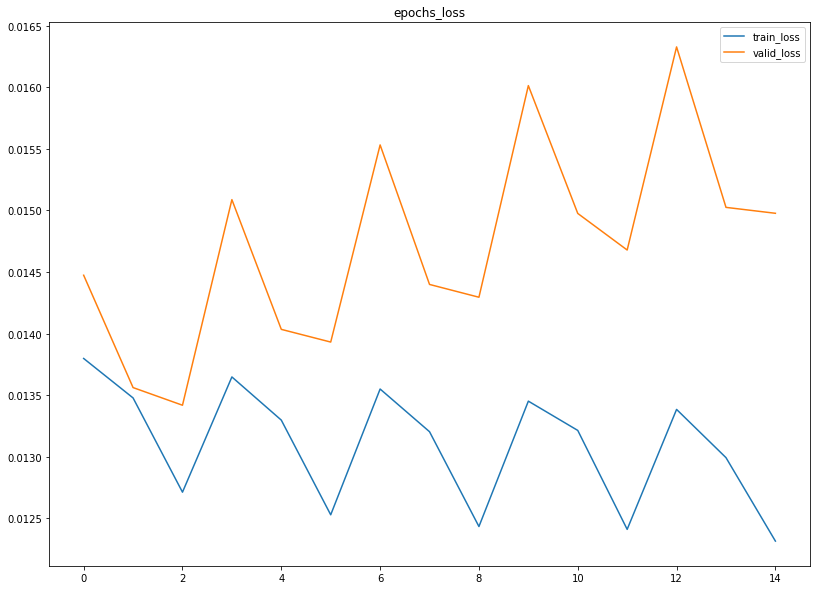

In [16]:
plt.figure(figsize=(30, 10))

# plt.subplot(121)
# plt.plot(train_loss[:])
# plt.plot(valid_loss[:])
# plt.title("train_loss")

plt.subplot(122)
plt.plot(train_epochs_loss, label="train_loss")
plt.plot(valid_epochs_loss, label="valid_loss")
plt.title("epochs_loss")
plt.legend()
# plt.savefig("./Tmax100-loss.png")
plt.show()

print results

In [17]:
index = ['accuracy', 'aupr_micro', 'aupr_macro', 'auc_micro', 'auc_macro', 'f1_micro', 'f1_macro', 'precision_micro', 'precision_macro', 'recall_micro', 'recall_macro']
all_ = pd.DataFrame(result_all, index=index)
each = pd.DataFrame(result_eve)
each.columns = ['accuracy', 'aupr', 'auc', 'f1', 'precision', 'recall']

In [18]:
all_

,0
accuracy,0.272195
aupr_micro,0.177835
aupr_macro,0.045991
auc_micro,0.726108
auc_macro,0.580512
f1_micro,0.272195
f1_macro,0.014264
precision_micro,0.272195
precision_macro,0.009073
recall_micro,0.272195


In [19]:
each

,accuracy,aupr,auc,f1,precision,recall
0,0.272195,0.636098,0.5,0.427914,0.272195,1.0
1,0.830244,0.584878,0.5,0.000000,0.000000,0.0
2,0.846829,0.576585,0.5,0.000000,0.000000,0.0
3,0.917073,0.541463,0.5,0.000000,0.000000,0.0
4,0.922927,0.538537,0.5,0.000000,0.000000,0.0
5,0.958049,0.520976,0.5,0.000000,0.000000,0.0
6,0.959024,0.520488,0.5,0.000000,0.000000,0.0
7,0.960976,0.519512,0.5,0.000000,0.000000,0.0
8,0.979512,0.510244,0.5,0.000000,0.000000,0.0
9,0.980488,0.509756,0.5,0.000000,0.000000,0.0
